# MAC and Model Correction or Updating of the FE models using Test Data
#### By Sainag Immidisetty






In [2]:
%load_ext autoreload
%autoreload 2
import pylab
import mpld3
import control as ctrl
import vibrationtesting as vt
from vibrationtesting import sos_modal
import matplotlib.pyplot as plt
import scipy
import numpy as np
import scipy.io as sio
import array_to_latex as a2t
from scipy.sparse import *
from OpenModal import *
import OpenModal as om
#from OpenModal.analysis.utility_functions import prime_factors
import OpenModal.analysis as ana
#from PyFRF.fft_tools impro
from pyFRF import FRF

np.set_printoptions(precision = 9, linewidth = 220, suppress = True)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


##### Purpose of bridging the gap between Testing and FE-Simulation:

Product development process have been modifying every now and then, at present most of the companies don't use simulation unless they first establish trust. So, first preference is given to validation at the test condition to use the right modeling techniques in simulation so that the variations can be looked at and the model could be used for development a head of time to see certain phenomenon that would replicate real world. 


## The Wing Structure:

Length, Width, Thickness and Airfoil profile coordinates were collected from this Structure to create a FE-models:

Ideally if we want to do a free-free test, we need to mount the structure to spring or bungee cords with a very low resonance frequency but as the first resonance is quite high so clamping on one-end is not a bad idea.


**Very Important Note:** Shaker placement in the picture was wrong, this was corrected while the experiment was conducted and this will be explained below in the shaker section.
![alt](img/image[4].jpeg )


# Experimental Modal Analysis :



**System Analysis**: Combined processing of an excitation and response signals, representing the device under test (DUT) natural responses or resonances, with no other disturbances.

System Analysis can be expanded to almost any complex structure. For instance, an engine 
![alt](img/excitation_response.png)

System Analysis primarily calculates the Frequency Response which is the response divided by the excitation.

![Ideal System(no noise)](img/idealsystem)

The general assumption while doing modal analysis is that the system is linear. However, that is not always true. Linearity check of the system was done experimentally and explained below.

# Impulse Response Function:

It describes how the structure decays over time when impacted. The following is a SDOF system but in reality unless we build one, we would not get this single wave decaying when we impact. So, if we have SDOF impulse response function then from that we can get the frequency by looking at the period of a complete oscillation, the decay gives us the damping and magnitude indicates the strength of the signal, it's the same information that we would have from the FRFs. 
![Ideal System(no noise)](img/sdofsystem)
![Ideal System(no noise)](img/Formulas)

However, when we hit any structure every resonance adds up together and will appear as shown below with a real data collected.

### Demonstration of Time and Frequency Responses for the wing model: (MDOF system)

(0, 350)

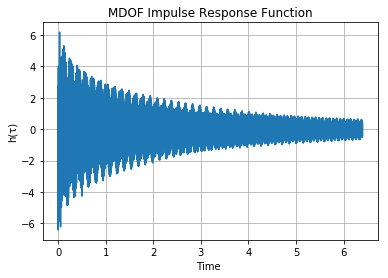

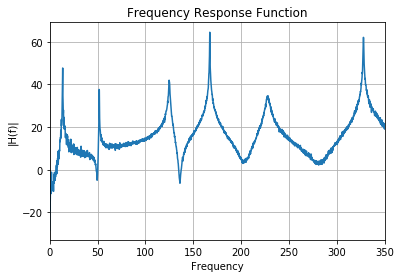

In [54]:
%matplotlib inline
mat_contents=sio.loadmat('SystemAnalysis/1.mat')

Frequency= mat_contents['Freq_domain']
Frequency= np.array(Frequency)
H = mat_contents['Hf_chan_2']


Time = mat_contents['Time_domain']
h = mat_contents['Time_chan_2']
             
fig=plt.figure()
plt.title('MDOF Impulse Response Function')
plt.plot(Time, (h))
plt.xlabel('Time ')
plt.ylabel('h(τ)')
plt.grid()

fig=plt.figure()
plt.title('Frequency Response Function')
plt.plot(Frequency, 20*np.log10(abs(H)))
plt.xlabel('Frequency')
plt.ylabel('|H(f)|')
plt.grid()
plt.xlim(xmax=350, xmin=0)



### Impulse response - No Frequency weighting:

The impulse response from all the resonance combined gives a mixed decay curve not usable for an estimation of a specific resonance decay.

Below is the exact same data as above shown with plus and minus decay, as we know an exponential decay on the linear scale becomes a straight line on the log scale. All the modes are super imposed over each other in this example. 

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.


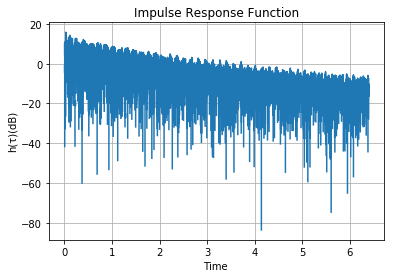

In [3]:

fig=plt.figure()
plt.title('Impulse Response Function')
plt.plot(Time, 20*np.log10((h)))
plt.xlabel('Time ')
plt.ylabel('h(τ)(dB)')
plt.grid()

### Impulse response - with Frequency weighting:

However, if we have the ability to do some filtering over one resonance to eliminated the others from the impulse response calculation then we will get a nice straight line. As of now, this remains as an information in this notebook but will be implemented in a while. We need to keep in mind that here the main idea is that if we filter with a little window then we eliminate all of the other resonances but this method is only possible when the frequency response shows nice clean resonances that are well separated which means they are decoupled. Like in complex structures where we might have a few resonance at low frequency which are fine but when we go up in frequency the modes get more and more closer to each other and that would be a mess and we cannot use filters in that case to separate resonances. 

** Figure below gives the idea of applying weighting using a software**

![Ideal System(no noise)](img/weighting)

So, in the figure, if we observe the decay that corresponds to 8.7 dB on a dB scale that's for one time constant for the decay

**Reasons of using the weighting:**
- In the frequency domain, when a resonance has very little damping then the shape of the resonance would be very narrow, in that case, it would be difficult to estimate 3 dB band width accurately because the next point after or before the peak may be down by 7 or 8 or 9 dB.
- For a short resonance with very little damping, even if curve fitting can be done in a smart way, it becomes difficult. However, in the time domain, it is not an issue when there is very little damping, only thing that happens would be that the decay would be for a longer time and the error in the time increment is very small compared to the time that that we measure. Hence, damping can be accurately measured in the time domain if we have the capability to apply the filter to see only on resonance at a time.
- The opposite is true if the damping is very high the the resonance in frequency domain is going to be wide, in that case it will be easy to go down accurately measure 3 dB band width. In the time domain, delta t error over time τ is very significant, so that's not good way to calculate damping in this case.

# Transducers and Exciters used:


A minimum of two channels are required to measure the signals coming out of the sensors simultaneously to do modal testing. Typically, Channel-1 corresponds to the impact hammer/electromagnetic shaker and Channel-2 to the accelerometer.

### Accelerometers: 

Accelerometers are very important in the process of data collection, there is nothing worst than using a pretty good transducer for a wrong job because that will not result in good data and could destroy the transducer.

TEDS stands for Transducer Electronic Data sheet, it is a chip that is embedded in the accelerometer. So, with TEDS transducers, all the relevant information is read from the chip and entered in the database and measurement setup. Where as if non TEDS transducers are used proper calibration data should be made available in the system data base.

TEDS information include Model Type number, Serial number, Sensitivity, Manufacture and more.

![Ideal System(no noise)](img/accels)

**Considerations**:
- **Types: Capacitive MEMS, Piezoelectric, or Piezoresisitve**

There are three main types of accelerometers: capacitive MEMS, piezoelectric, and piezoresistive. The accelerometer's datasheet will, or should, tell you exactly what type it is because picking the right accelerometer type for your application can make all the difference.  Generally a capacitive MEMS accelerometer is best for motion sensing applications (think human motion which is relatively slow/low frequency); piezoelectric is best for vibration; and piezoresistive is best for shock testing.

**Piezoelectric Accelerometer:**
Basic idea behind using piezoelectric ceramic element: This element behaves like a quartz (pure quartz is used in standard reference accelerometers, less sensitivity but very stable) when we apply compressive or shear stress to it then 
generates a high-impedance, electric charge proportional to the applied force, and thus, proportional to the acceleration. Shear design is most commonly used. 

The following is something important to keep in mind, accelerometer are sensitive to many things like the following, the ones that are rounded effects the modal analysis and the others can be controlled as we do modal analysis in lab environment.
![Ideal System(no noise)](img/envieffects)


- **Validation:** This is a regular way of calibrating the accelerometer when say if it is dropped on the ground, the calibrator usually standardized to check for 159.2 Hz frequency (1000 rad/sec) and 1g (10 meter per square second) acceleration.

- **Weight:** Every accelerometer is also a mass-spring system, so, one big factor when we do modal analysis is Mass Loading, so if the dynamic mass of it is significant then that will change the natural frequencies of the system.

- **Sensitivity:** Sensitivity of an accelerometer defines at what rate the sensor converts mechanical energy into an electric signal (the output); and this will define the acceleration measurement range of the accelerometer.  Sensitivity is usually expressed as mV/g. The sensitivity that we desire depends on the level of the signal you wish to measure.  If we are interested in small vibrations then a higher sensitivity will be desirable to provide a cleaner signal (higher signal to noise ratio). The price to pay for a higher sensitive accelerometer is it's weight, following figure illustrates that:
![Ideal System(no noise)](img/sensitivity)

- **Mounting:** A stud in theory is the best method to mount an accelerometer but as sometimes it's not possible then we can use glue, adhesive tape, bees wax, dental cement etc.

- **Cables:** Rattling of cables on the structure, and interception with electric wires would cause noise that results in bad quality data as they are uncorrelated vibration.

- **Others:** Other important considerations are Frequency response or Bandwidth, Measurement range, Noise, Resolution, Filtering, uni or triaxial etc.


















# Impact Hammers: (Non-attached)

Impact Hammers come in different sizes(1 pound, 3 pounds, 12 pounds and even bigger). The tip of the hammer can be unscrewed from the load cell and be replaced. That's the way the duration of the impact is controlled, and that pulse duration is inversely proportional to the Frequency bandwidth.

**Magnitude and pulse duration depends on:**
- Weight of hammer
- Hammer tip (steel, plastic or rubber)
- Dynamic characteristics of surface
- Velocity at impact

![Ideal System(no noise)](img/hammers)

When using  a hammer as the method of excitation, one should make sure that there is good energy getting out to our frequency of interest, tips play a major role in this process which is demonstrated below with real data:

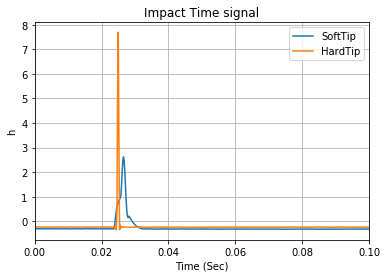

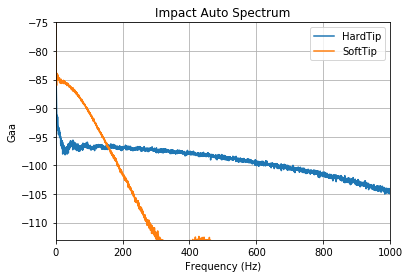

In [4]:
mat_contents=sio.loadmat('hammer/metaltip.mat')
Frequency= mat_contents['Freq_domain']
Metaltipimpactspec = mat_contents['PSD_chan_1']

Time = mat_contents['Time_domain']
Metaltipimpacttime = mat_contents['Time_chan_1']

Frequency= mat_contents['Freq_domain']
Metaltipimpactspec = mat_contents['PSD_chan_1']

mat_contents=sio.loadmat('hammer/plastictip2.mat')
Frequency= mat_contents['Freq_domain']
rubbertipimpactspec = mat_contents['PSD_chan_1']
Time = mat_contents['Time_domain']
rubbertipimpacttime = mat_contents['Time_chan_1']

Frequency= mat_contents['Freq_domain']
rubbertipimpactspec = mat_contents['PSD_chan_1']


fig=plt.figure()
plt.title('Impact Time signal')
plt.plot(Time, rubbertipimpacttime, label='SoftTip')
plt.plot(Time, Metaltipimpacttime, label='HardTip')
plt.xlabel('Time (Sec)')
plt.ylabel('h')
plt.grid()
plt.xlim(xmax=.1, xmin=0)
plt.legend()
plt.show()

fig=plt.figure()
plt.title('Impact Auto Spectrum')
plt.plot(Frequency, 20*np.log10(abs(Metaltipimpactspec)), label='HardTip')
plt.plot(Frequency, 20*np.log10(abs(rubbertipimpactspec)), label='SoftTip')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Gaa')
plt.grid()
plt.xlim(xmax=1000, xmin=0)
plt.ylim(ymax=-75, ymin=-113)
plt.legend()
plt.show()

**Observations:** 
- We can clearly see that the narrower the duration of impact, the longer the spectrum in the frequency domain called broad band excitation. And the longer the duration of impact, the narrower the spectrum that is the spectrum rolls-off. 
- So, the soft tip excites lower frequencies better than the hard tip, and the hard tip excites higher frequencies better.
- For, our experiment here the softer tip is not appropriate since it drops at about 300 Hz. However, the hard tip tends to agree.


- **Advantages of the Hammer impact:** Speed, No fixturing, No variable mass loading, Portable and highly suitable for field work, relatively inexpensive, useful for determining shaker and support locations.
- **Disadvantages:** High crest factor which means possibility of driving structure into non-linear behavior, Tip performance is often overlooked, Not good for very large structures, Repeatable hammer strikes require 'calibrated elbow'.

**Note:** Metal tip when used on metallic structures can indent the structure, and goes non-linear. So, the impact needs to be really soft.

- **Validation:**  If we have known mass and accelerometer mounted on it, then we can impact the mass and get the FRF which is acceleration divided by force or one over the mass (F=m*a). So, 1/FRF = Mass. This kind of test should give us the combined mass of the accelerometer and the calibrated mass. Care must be taken in maintaining consistency of units, it's easy in the SI system where the mass is in KGs, the measurement in meters and the force in Newtons. We will notice the phase to be flat if every thing is good.
![Ideal System(no noise)](img/hamrvalidation)



### Demonstranting Double hit and the resulting ASD:

/home/sainag/.local/lib/python3.5/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


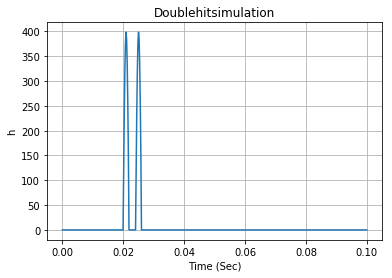

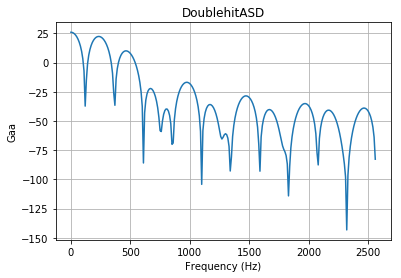

In [5]:
time= np.linspace(0,0.1,513).reshape(1,-1)
force= vt.hammer_impulse(time,imp_time=0.02,imp_duration=0.002,doublehit=True,dh_delta=0.04)
fig=plt.figure()
plt.title('Doublehitsimulation')
plt.plot(time.T, force.T)
plt.xlabel('Time (Sec)')
plt.ylabel('h')
plt.grid()
plt.legend()
plt.show()

[freq,Pff]=vt.asd(force,time,windowname="none")
freq= freq.reshape(1,257)

fig=plt.figure()
plt.title('DoublehitASD')
plt.plot(freq.T, 20*np.log10(abs(Pff.T)))
plt.xlabel('Frequency (Hz)')
plt.ylabel('Gaa')
plt.grid()
plt.legend()
plt.show()

** Ramifications of double hit in an actual test:**
The oscillations in the Hammer Auto spectrum occur due to douple or multiple hits. This would add additional noise to the FRF. Peaks at natural frequecies can still be seen, however, additional fake peaks also appear in the FRF which would be confusing. And the mode shapes of the structure will look weird as those oscillation in the Hammer Auto spectrum adds extra contributions. Hence, double hits are not at all a compromise.  

### Setting up the Hammer:

- The first thing to do is to determine how high of an impact that we are going to generate, the idea being  the identification of which level is above noise. However, the impact has to only sufficiently high that we don't easily trigger on softer hits. So, before starting the test, we can run a free test and determine the trigger threshold.
- Hysteresis: The hysteresis is quite optional, we don't need to have much hysteresis, it is to prevent multiple trigger when we cross the threshold. So, hysteresis is not critical. Usually, 1/5th of the trigger level is used for hysteresis. If we trigger at 10 N then 2 N hysteresis would be fine.
- Pre-trigger samples: We always need to make sure that the rise of the impact signal is not missed, essentially the entire impact pulse should be seen. So, to do that we go back in time and get data before triggering. That's called Pre-trigger, and a good rule of thumb is to fix that value to 5% of the block size which means 5% before trigger and 95% after the trigger.


### Weighting Function for impact excitation: 

The purpose of the force window is to improve the signal-to-noise ratio of the measured input by eliminating the noise on the signal following the duration of the impact and also the noise on the signal before the impact.
![alt](img/transient)


# Shaker (attached)

### Modal Shakers


Excitation using a shaker can give better results, more consistency when compared to the impact hammer.There have been number of methods over the years to excite the structure using a shaker. 

Typically, we use an electro-magnetic shakers, these are like a big speaker with a cone because these are built in the same way consisting of magnet, coil and suspension which drives the shaker. For instance, a bigger shaker can play music but it will play like a poor speaker without a cone.

The shaker can be mounted horizontally and so excitation in horizontal direction can be done. For vertical excitation, usually it is put on the floor or on the stack of ply-wood so that we can excite well, but horizontally it is so difficult to do that. That is the reason stand is provided to the shakers.

**Shaker specifications include:**  Force rate, Frequency range, Max. rated travel (inch peak-to-peak), Armature effective mass, weight with trunnion, Power Amplifier Type, DC static Centering Unit optional.

They have a robust design, can take beating for many years, and they come in different sizes, we can see few of them in the figure  below:

![alt](img/shakers)

**Important things to know while Connecting shaker to a structure:**

- The thing to keep in mind is that when we are physically attaching  a shaker to the structure, the force transducer goes to the structure not on the shaker because the stringer which is attached or tied together between a force transducer and shaker is a filter to a degree and if we put the force transducer before the stinger then what we get on to the structure is not what we measure. So, it has to be on the structure.


- The shaker interior has a coil called the armature which has some physical characteristics due to it's weight. So, when we attach it to the structure that may add weight resulting in mass loading. That is one of the reasons shakers are normally used on very large objects so that the weight of the armature is not significant. To avoid this, there are also a low weight armature and those are good modal shakers which have magnesium armature that is light and stiff. If we consider another case for instance, of a very light test object hanging and we try to hit it with a big hammer but the object goes away. So, in all case it is important to scale the excitation weight with the weight of the test object. 


- The goal of the stringer is to send all the force to the structure in the axis of interest, the stringers are designed to be infinitely stiff in the axial direction but allows cross motion as much as we want in order to not prevent the structure from deforming one way or the other. So, these are the two requirement with the stringer, allow cross motion but being infinitely stiff in it's axial direction.


- The attachment point in the shaker to hold the stringer is a thru-hole. And the reason for that is because of one of the very good way to attach the shaker to the structure is by using a piano wire which is a flexible wire. So, we mount force transducer on the object and attach the cable down to that fixture, lock it in a way pre-tension of it is to the maximum. The piano wire is very stiff in push, pull but soft in cross axis. The minus point of using a piano wire instead of a stringer is that the range of frequencies could be up to 200 Hz.


- When it comes to the force applied, we should try to distribute the force if possible, this way we can prevent not to have extremely high force at only one point and not any where else, that is reason behind using more number of shakers.


- If we have a test object that is quite large, it could have lot of displacement. So, the motion of the shaker should be fairly large as well. For such applications there are shakers that can have up to 2 inch peak-to-peak, which will be a good choice.


- Another thing we see about shaker is that, the attachment point is very small. The armature and head is designed for modal but not for fatigue testing. And, it is not ideal to use general purpose shakers for modal.


-

### Four steps to Modal Analysis with a shaker


- Excitation of the structure at one point by shaker with force transducer


- Response measured at a number of points


- FRF’s between excitation point and measurement points calculated


- Modes of structure identified






### Modal Test set-up challenge:

- Case 1: The ideal mounting method is the shaker being supported to produce force to an object which is floating. 
- Case 2: Both the shaker and the object are floating.
- Case 3: This is not a good idea as both are supported and the shaker is placed under the structure vertically, here the force transmits back. We should make sure that isolation is good to the force that we are injecting into the structure and only goes to force transducer so that we measure it all. Therefore, it is important to not have force behind the force transducer, this will give bad coherence resulting in bad results.

![alt](img/shaker1)


- **Advantages of the Hammer impact:** Repeatable due to electronic control, Wide range of excitations, Can excite very small thru very large structures, More automated test.
- **Disadvantages:** More equipment required than hammer, Skilled operators necessary to supervise test, A lot of setup time required, Shaker issues such as: stringers, mounting of shaker, proper shaker selection.



# Dual Channel FFT Analysis







![alt](img/Dualchannelspectrum)**Note:** This chart has not changed since 30 years. However, the number of channels have been considerably increased. From one excitation - one response to one excitation - multiple response to multiple excitation - multiple response. 

**Description of the Chart above:**
Assume channel.A corresponds to excitation and Channel.B to response, we gather time data through the A/D converter and anti-aliasing filter, then do Fourier transformation to get a fourier spectrum and as we do averaging we multiply signals by themselves that gives the name Gaa and Gbb (Autospectrum, has no phase) whose inverse fourier transform gives Auto correlation(Raa and Rbb). Both the signals from Fourier spectrum are brought together to calculate the Cross-spectrum(Gab) where phase is preserved. 
With the cross spectrum and the auto spectrum we can calculate the FRF and the Coherence which are valuable functions. The other functions are not quite often used in Modal, essentially, we use the FRF, the Coherence and the Impulse response(by taking inversed fourier transform of Frequency Response). 




**Advantages of Dual-channel FFT Analysis:**

* Phase information is available. Phase gives complete description of the structure and we will be able to do proper animation as well.
* Effects of noise are minimized through AVERAGING. Note: when we excite the structure with the miniature shaker, the signal that we use is called random noise. However, it's random excitation. Noise which is minimized here is external vibration or forces that are not coming out of the generator that disturb our measurement. So, that uncorrelated contribution from environmental vibration will be  reduce by averaging.
* A controlled input signal is not needed. So, controlling the excitation amplitude and frequency tightly is not a requirement because if the force spectrum is going up and down within like 20-30 dB, it's not a big deal because the transducer has a large dynamic range and also the front end (160 dB typically) so we can measure every thing accurately. The response will follow the excitation profile to some degree. And once we combine the two different signals together they will normalize.
* Easy tool to use once we know how to set up the Analyzer.
* Extension, for instance to Modal Analysis.

**Pitfalls of Dual-channel FFT Analysis:**

* Leakage
* A linear system is assumed


#  Leakage: 

It is the result of underestimating the peak either at the valley or at the resonance.

** To prevent leakage:**

1. Use optimum time weighting function
2. Increase the resolution
3. Choose optimum excitation


## 1. Using Optimum time weighting function:

 It is a result of not having time data acquisition until infinite time. In reality, we have the beginning and the end. So, we need to add some weighting to prevent leakage.


**Ideal Case**: It almost never happens for a signal like sine wave containing even number of cycles which means that the beginning and the end of time is continuous. Because the FFT process takes that time data block, loop it and analyze constantly so it looks perfectly continuous and thats the ideal case which do not require windowing to prevent leakage. If we add window to that case then that would over estimate damping making the mode look wider than it should be.
![alt](img/idealcase)
**Real cases require window to prevent leakage to some extent**: Real world time data is collected as a block which has a size and is not continuous at the beginning and the end. When we do FFT there will be drop in amplitude, poor spectrum filter profile. So, we need to apply weighting functions to control leakage as much as possible.  
![alt](img/realcase)

### Demonstration of windowing with Exponential for Impact time response and Hanning for Random response

expwin is untested


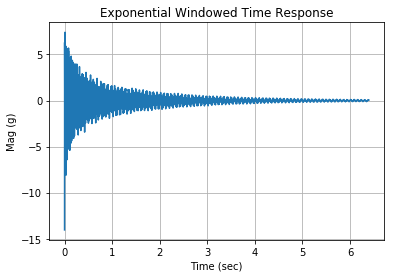

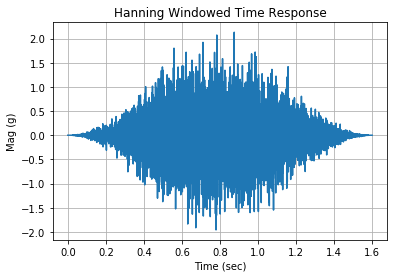

In [6]:
%matplotlib inline
mat_contents=sio.loadmat('modaldata/rawdata_1.mat')
Time_data= mat_contents['Time_domain']
Time_data= np.array(Time_data)
a=vt.expwin(len(Time_data),ts=2)
Time_data= np.transpose(Time_data)
rawresponse1= mat_contents['Time_chan_2']
rawresponse1 = np.array(rawresponse1)
windowedsig= np.transpose(rawresponse1)*a

fig=plt.figure()
plt.title('Exponential Windowed Time Response')
plt.plot(Time_data.T, windowedsig.T)
plt.xlabel('Time (sec)')
plt.ylabel('Mag (g)')
plt.grid()

mat_contents=sio.loadmat('linearitycheck/high.mat')
Time_data= mat_contents['Time_domain'] 
Time_data= np.array(Time_data)
a=vt.hanning(len(Time_data))
averagedsig= mat_contents['Time_chan_2']
Time_data= np.transpose(Time_data)

averagedsig = np.array(averagedsig)
windowedsig= np.transpose(averagedsig)*a
fig=plt.figure()
plt.title('Hanning Windowed Time Response')
plt.plot(Time_data.T, windowedsig.T)
plt.xlabel('Time (sec)')
plt.ylabel('Mag (g)')
plt.grid()

### Demonstrating window effecting the spectrum as explained above:

expwin is untested


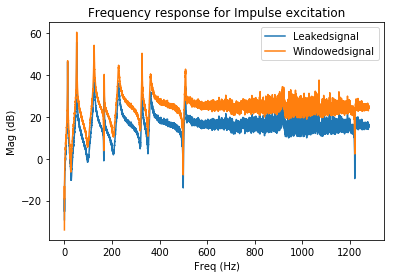

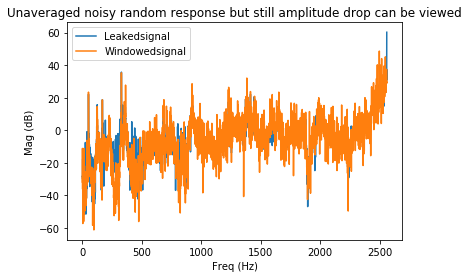

In [7]:
%matplotlib inline
mat_contents=sio.loadmat('modaldata/rawdata_1.mat')
Time_data= mat_contents['Time_domain']
Time_data= np.array(Time_data)
a=vt.expwin(len(Time_data))
Time_data= np.transpose(Time_data)
rawimpact1 = mat_contents['Time_chan_1']
rawimpact1 = np.array(rawimpact1)
rawresponse1= mat_contents['Time_chan_2']
rawresponse1 = np.array(rawresponse1)
windowedresponse1= np.transpose(rawresponse1)*a

x=np.array([rawresponse1]).reshape(1,16384,1)

xwindowed=np.array([windowedresponse1]).reshape(1,16384,1)

f=np.array([rawimpact1]).reshape(1,16384,1)

[freq,Pxx]=vt.asd(x,Time_data,windowname="none")
[freq,Pff]=vt.asd(f,Time_data,windowname="none")
[freq,Pxf]=vt.crsd(f,x,Time_data,windowname="none")

[freq,Pxxwindowed]=vt.asd(xwindowed,Time_data,windowname="none")
[freq,Pxfwindowed]=vt.crsd(f,xwindowed,Time_data,windowname="none")

Pxx= np.array([Pxx]).reshape(1,8193)

freq=np.array([freq]).reshape(1,8193)

freq=np.array(freq)
H1=np.conj(Pxf/Pff)
H1=np.array([H1]).reshape(1,8193)
H1=np.array(H1)

H1windowed=np.conj(Pxxwindowed/Pxfwindowed)
H1windowed=np.array([H1windowed]).reshape(1,8193)

FRFs= np.column_stack((H1,H1windowed))
FRFs=np.array(FRFs)


fig = plt.figure()
ax = plt.subplot(111)
ax.plot(freq.T, 20*np.log10(abs(H1)).T, label='Leakedsignal')
ax.plot(freq.T, 20*np.log10(abs(H1windowed)).T, label='Windowedsignal')
plt.title('Frequency response for Impulse excitation')
plt.xlabel('Freq (Hz)')
plt.ylabel('Mag (dB)')
ax.legend()
plt.show()

mat_contents=sio.loadmat('linearitycheck/high.mat')
Time_data= mat_contents['Time_domain']
Time_data= np.array(Time_data)
a=vt.hanning(len(Time_data))
Time_data= np.transpose(Time_data)
rawimpact1 = mat_contents['Time_chan_1']
rawimpact1 = np.array(rawimpact1)
rawresponse1= mat_contents['Time_chan_2']

rawresponse1 = np.array(rawresponse1)
windowedresponse1= np.transpose(rawresponse1)*a


x=np.array([rawresponse1]).reshape(1,8192,1)


xwindowed=np.array([windowedresponse1]).reshape(1,8192,1)

f=np.array([rawimpact1]).reshape(1,8192,1)

[freq,Pxx]=vt.asd(x,Time_data,windowname="none")
[freq,Pff]=vt.asd(f,Time_data,windowname="none")
[freq,Pxf]=vt.crsd(f,x,Time_data,windowname="none")

[freq,Pxxwindowed]=vt.asd(xwindowed,Time_data,windowname="none")
[freq,Pxfwindowed]=vt.crsd(f,xwindowed,Time_data,windowname="none")

Pxx= np.array([Pxx]).reshape(1,4097)

freq=np.array([freq]).reshape(1,4097)
freq=np.array(freq)
H1=np.conj(Pxf/Pff)
H1=np.array([H1]).reshape(1,4097)
H1=np.array(H1)
H1windowed=np.conj(Pxxwindowed/Pxfwindowed)
H1windowed=np.array([H1windowed]).reshape(1,4097)
FRFs= np.column_stack((H1,H1windowed))
FRFs=np.array(FRFs)


fig = plt.figure()
ax = plt.subplot(111)
ax.plot(freq.T, 20*np.log10(abs(H1)).T, label='Leakedsignal')
ax.plot(freq.T, 20*np.log10(abs(H1windowed)).T, label='Windowedsignal')
plt.title('Unaveraged noisy random response but still amplitude drop can be viewed')
plt.xlabel('Freq (Hz)')
plt.ylabel('Mag (dB)')
ax.legend()
plt.show()

### Exponential weighting:

Basically, with exponential window, we can add some decay without killing the whole thing. We can avoid this window if more time is allowed for the measurement. It works both way, we can compensate for the weighting later, as it is demonstrated and explained below:

expwin is untested


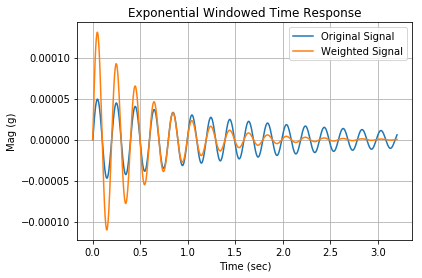

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:29: RuntimeWarning: divide by zero encountered in log10
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in log10


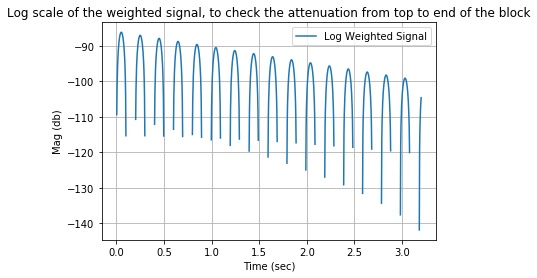

In [8]:
sys = vt.so2ss(np.array([[1]]),np.array([[1]]),np.array([[1000]]),
               np.array([[1]]),np.array([[1]]), np.array([[0]]), np.array([[0]]))
sys = ctrl.ss(*sys)
U = np.zeros((1,1000))
U[0,0]=1
X0=np.array([[0],[0]])
T = np.linspace(0,3.2,1000)
T, yout, xout = ctrl.forced_response(sys,U=U,T=T,X0=X0)


a=vt.expwin(len(T),ts=0.75)
windowedsig= np.transpose(yout)*a
T= T.reshape(1,1000)

fig=plt.figure()
plt.title('Exponential Windowed Time Response')

plt.plot(T.T,yout.T, label='Original Signal')
plt.plot(T.T, windowedsig.T, label= 'Weighted Signal')

plt.xlabel('Time (sec)')
plt.ylabel('Mag (g)')
plt.grid()
plt.legend()
plt.show()

fig=plt.figure()
plt.title('Log scale of the weighted signal, to check the attenuation from top to end of the block')
plt.plot(T.T, 20*np.log10(yout.T), label= 'Log Weighted Signal')

plt.xlabel('Time (sec)')
plt.ylabel('Mag (db)')
plt.grid()
plt.legend()
plt.show()

**Importance of viewing in Log Scale:** If we convert the weighted signal to the log scale, we can see the amount of attenuation from the top to the end of the block, the rule of thumb is if we have 50 dB attenuation from the top to the end then it is good enough. So, we shouldn't apply too much external weighting to the signal that it will kill it. The log graph plotted above show that we have around 20 dB attenuation which is a good value to have which means that the beginning and the end are pretty close and that would minimize leakage. 

**Correction:**
- The goal of exponential window is to fit the entire signal inside the window, which means that the amplitude at the end is zero. 
- With exponential weighting of the output signal, the measured time constant will be too short and the calculated decay constant and damping ratio therefore too large. A correction for exponential weighting is required as shown below.

![alt](img/weigting)
![alt](img/compensation)

**Note:** 
- In addition to choosing exponential window, we need to keep in mind that if we measure for too short duration we could loose good data by accident.
- The common mistake is to say that we added damping to the signal when windows are used but it's not damping, we actually added decay.

## 2. Leakage due to less Resolution: 

* when resolution is low, that means that there are less points to represent the curves digitally and these points need not necessarily be at the maximum. So, this could cause a reduction in amplitude underestimating the peak either at the resonance or the valley or both. 
* So, in order to reduce the leakage we need to increase the resolution which means to measure for longer period of time and we can also reduce the leakage by choosing H2 for resonance and H1 for the anti-resonance.


#### Demonstrating leakage due to resolution with Random Excitation:
- Shaker was ran in random mode and seen the impact of different acquisition settings on the coherence and noticed how this can have significant changes to the system.
- Initialized the test and set a safe voltage level for the shaker by scrolling the bar up and down to adjust in terms of percentage for security reasons, here I used 100% as it's fine to use full voltage as here we have a bigger system to shake with that high force. However, if we test on a satellite which is million dollar worth then we got to be careful but here it doesn't matter so much.
- So, the pure random excitation upto 2KHz was used with a poor frequency resolution of 8Hz which means we measured the data for 1/8th of a second. 
- Then, ran  the random again as a second case for 1.6 seconds which is 1/1.6 Hz resolution which is high. And the demonstration and observations are explained below:

(100, 300)

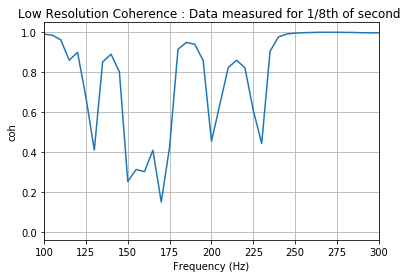

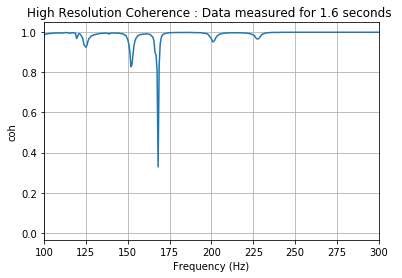

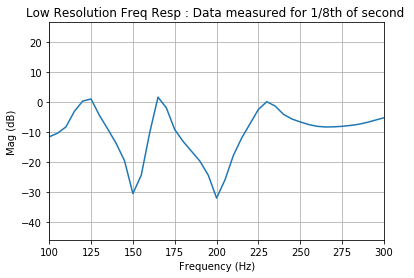

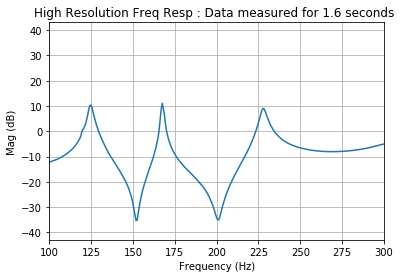

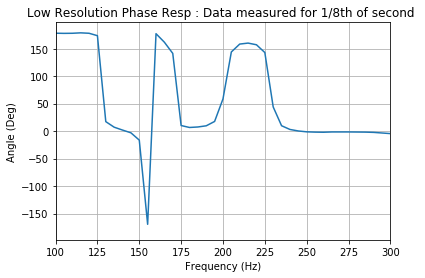

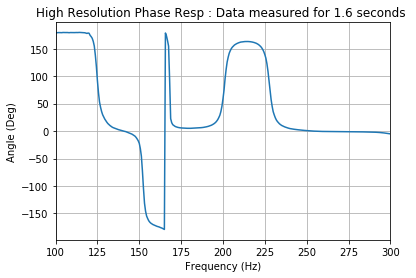

In [9]:
%matplotlib inline
mat_contents=sio.loadmat('Resolution/highresolution.mat')
Frequencyhigh= mat_contents['Freq_domain']
Frequencyhigh= np.array(Frequencyhigh)
#Frequency= np.transpose(Frequency)
Highresolutionresponse = mat_contents['Hf_chan_2']
Highresolutionresponse = np.array(Highresolutionresponse)
coh = mat_contents['Hf_coh_chan_2']
cohhighresolution = np.array(coh)

mat_contents=sio.loadmat('Resolution/Lowresolution.mat')
Frequencylow= mat_contents['Freq_domain']
Frequencylow= np.array(Frequencylow)
lowresolutionresponse = mat_contents['Hf_chan_2']
lowresolutionresponse = np.array(lowresolutionresponse)
coh = mat_contents['Hf_coh_chan_2']
cohlowresolution = np.array(coh)

fig=plt.figure()
plt.title('Low Resolution Coherence : Data measured for 1/8th of second ')
plt.plot(Frequencylow, cohlowresolution)
plt.xlabel('Frequency (Hz)')
plt.ylabel('coh')
plt.grid()
plt.xlim(xmax=300, xmin=100)

fig=plt.figure()
plt.title('High Resolution Coherence : Data measured for 1.6 seconds ')
plt.plot(Frequencyhigh, cohhighresolution)
plt.xlabel('Frequency (Hz)')
plt.ylabel('coh')
plt.grid()
plt.xlim(xmax=300, xmin=100)

fig=plt.figure()
plt.title('Low Resolution Freq Resp : Data measured for 1/8th of second ')
plt.plot(Frequencylow, 20*np.log10(abs(lowresolutionresponse)))
plt.xlabel('Frequency (Hz)')
plt.ylabel('Mag (dB)')
plt.grid()
plt.xlim(xmax=300, xmin=100)

fig=plt.figure()
plt.title('High Resolution Freq Resp : Data measured for 1.6 seconds ')
plt.plot(Frequencyhigh, 20*np.log10(abs(Highresolutionresponse)))
plt.xlabel('Frequency (Hz)')
plt.ylabel('Mag (dB)')
plt.grid()
plt.xlim(xmax=300, xmin=100)

fig=plt.figure()
plt.title('Low Resolution Phase Resp : Data measured for 1/8th of second ')
plt.plot(Frequencylow, np.degrees(np.angle(lowresolutionresponse)))
plt.xlabel('Frequency (Hz)')
plt.ylabel('Angle (Deg)')
plt.grid()
plt.xlim(xmax=300, xmin=100)

fig=plt.figure()
plt.title('High Resolution Phase Resp : Data measured for 1.6 seconds ')
plt.plot(Frequencyhigh, np.degrees(np.angle(Highresolutionresponse)))
plt.xlabel('Frequency (Hz)')
plt.ylabel('Angle (Deg)')
plt.grid()
plt.xlim(xmax=300, xmin=100)





### Observations:
- We can see that the FRFs are not clean and also have big drops at resonances, it means that we have lot of leakage as peak is suppose to be sharp. So, we have very poor definition around the resonance because we have very few points there. This is also apparent in coherence plots.
- As the FRF plotted here corresponds to H1, there is no significant leakage at anti-resonances.





# Tests for validation of data:

1. Coherence
2. Linearity
3. Reciprocity
4. Drive Point
5. Free Mass Validation

## 1. Coherence: (Input-Output Relation):

This is a rule to always make sure our coherence is "1" or very close to 1 at the resonance. Coherence tells us how good is the measurement in terms of linearity, quality of the impact, and noise. So, it's a very valuable function. 

***Note***: Do not be too concerned if the coherence is something less than "1" at the anti-resonance.

**Ideal system with coherence 1**
![Ideal System(no noise)](img/idealsystem)

**Influence of noise that damage the FRF, thereby lowering the coherence**
![Ideal System](img/influenceofnoise)



## Averaging: 

If we have a little bit of unwanted environmental noise, that means the magnitude of the vector A or B or both would go bigger or smaller, this can be seen in their respective auto spectrum.

**Input Auto spectrum:** Auto spectrum means signal multiplied to itself. So, when input noise M is multiplied by itself becomes correlated and the noise contribution add to the true input signal.

![Alt](img/Saa)

**Output Auto spectrum:** Any of the auto spectrum includes noise contribution. Here N is output noise.

![Ideal System(no noise)](img/Sbb)

**Cross-Spectrum:** If we do the cross spectrum, we can get the true signal as noise will keep canceling out through averaging. Which means every time we multiply two signals that are uncorrelated like noise, the averaging result would be zero because the phase and amplitude both are random.

![Ideal System(no noise)](img/Sab)


**Number of Averages to be taken:** Depends on how much noise we have. In case of the wing structure, the accelerometer sensitivity was 100 mv/g, the structure is not so big and the vibration due to impact(using hammer) was sufficient to get a cleaner signal. So, only three data sets were averaged. However, if we have the transducer with 1 mv/g on a big structure and small excitation level, then at the end there is very little vibration. So the noise is going to be significant in amplitude compared to vibration, this will be problematic. 

In that case we are left with no other choices, so we need to use FRF estimators assuming that could solve the issue. This is demonstrated and explained below.

### Demonstration of three data sets being averaged to reduce noise:

(0, 350)

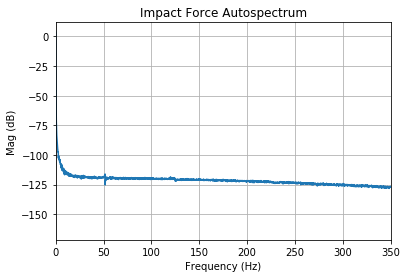

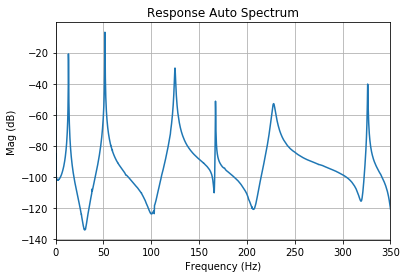

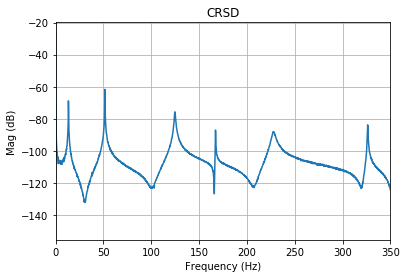

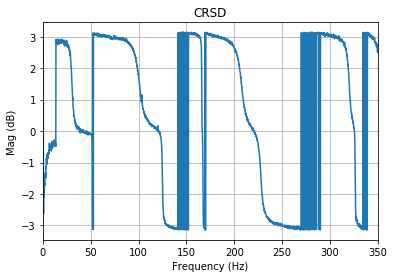

In [10]:
%matplotlib inline
mat_contents=sio.loadmat('modaldata/rawdata_1.mat')
Time_data= mat_contents['Time_domain']
Time_data= np.array(Time_data)
Time_data= np.transpose(Time_data)
rawimpact1 = mat_contents['Time_chan_1']
rawimpact1 = np.array(rawimpact1)
rawresponse1= mat_contents['Time_chan_2']
rawresponse1 = np.array(rawresponse1)
mat_contents=sio.loadmat('modaldata/rawdata_2.mat')
rawimpact2 = mat_contents['Time_chan_1']
rawimpact2 = np.array(rawimpact2)
rawresponse2= mat_contents['Time_chan_2']
rawresponse2 = np.array(rawresponse2)
mat_contents=sio.loadmat('modaldata/rawdata_3.mat')
rawimpact3 = mat_contents['Time_chan_1']
rawimpact3 = np.array(rawimpact3)
rawresponse3= mat_contents['Time_chan_2']
rawresponse3 = np.array(rawresponse3)

x= np.column_stack((rawresponse1,rawresponse2,rawresponse3))
x=np.array([x]).reshape(1,16384,3)

f= np.column_stack((rawimpact1,rawimpact2,rawimpact3))
f=np.array([f]).reshape(1,16384,3)

[freq,Pxx]=vt.asd(x,Time_data,windowname="none")

[freq,Pff]=vt.asd(f,Time_data,windowname="none")

[freq,Pxf]=vt.crsd(f,x,Time_data,windowname="none")

freq=np.array([freq]).reshape(1,8193)


fig=plt.figure()
plt.title('Impact Force Autospectrum')
plt.plot(freq.T, 20*np.log10(abs(Pff)).T)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Mag (dB)')
plt.grid()
plt.xlim(xmax=350, xmin=0)

fig=plt.figure()
plt.title('Response Auto Spectrum')
plt.plot(freq.T, 20*np.log10(abs(Pxx)).T)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Mag (dB)')
plt.grid()
plt.xlim(xmax=350, xmin=0)

fig=plt.figure()
plt.title('CRSD')
plt.plot(freq.T, 20*np.log10(abs(Pxf)).T)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Mag (dB)')
plt.grid()
plt.xlim(xmax=350, xmin=0)

fig=plt.figure()
plt.title('CRSD')
plt.plot(freq.T, np.angle(Pxf).T)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Mag (dB)')
plt.grid()
plt.xlim(xmax=350, xmin=0)


### FRF Alternative Estimators:  

If the coherence is good we can either go with either H1 or H2, the default FRF is H1. To be more accurate for the systems, below would be the best table to follow:

![alt](img/estimates)


### Demonstration of H1, H2, Coherence

(0, 350)

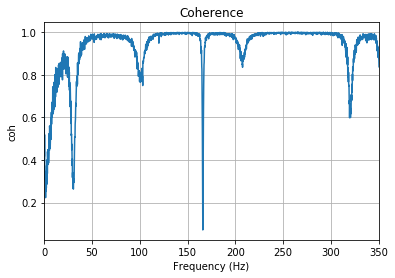

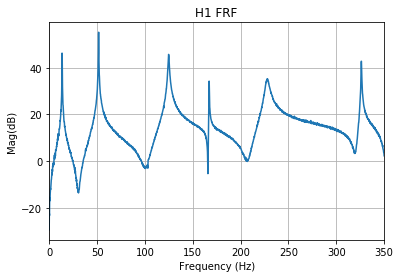

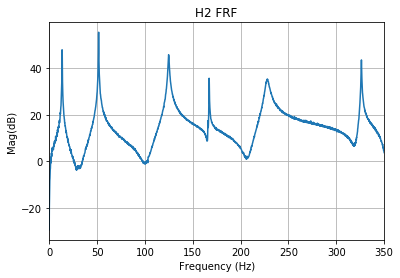

In [11]:
H1=np.conj(Pxf/Pff)
H2=Pxx/Pxf
coh=(Pxf*np.conj(Pxf)).real/Pxx/Pff

fig=plt.figure()
plt.title('Coherence')
plt.plot(freq.T, coh.T)
plt.xlabel('Frequency (Hz)')
plt.ylabel('coh')
plt.grid()
plt.xlim(xmax=350, xmin=0)

fig=plt.figure()
plt.title('H1 FRF')
plt.plot(freq.T, 20*np.log10(abs(H1)).T)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Mag(dB)')
plt.grid()
plt.xlim(xmax=350, xmin=0)

fig=plt.figure()
plt.title('H2 FRF')
plt.plot(freq.T, 20*np.log10(abs(H2)).T)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Mag(dB)')
plt.grid()
plt.xlim(xmax=350, xmin=0)


### Observations:  

If we observe H1 FRF as well as the coherence obtained which is almost 0.9 but we hit spots where the coherence is low and that would happen at the anti-resonance. Depending on how the modes add or subtract,  then we can have these deep valleys and this deep valley indicates that we have very little vibration, so small that we may be very close to the environmental noise so the coherence drop. However, it's not a bad to have low coherence at anti-resonance. 

#### Typical reasons for Low Coherence: 

*** Difficult measurements:***
- Noise in measured output signal
- Noise in measured input signal
- Other inputs not correlated with measured input signal



*** Bad measurements:***
- Leakage
- Time varying systems
- Non-linearities of system
- DOF-jitter

## 2. Linearity Checks:

A structure FRF is independent of the excitation if it is linear. So the Linearity check is done when exciting the structure at various levels obtaining the same values for the FRF.
![alt](img/Linearity)

**Averaging:** The averaging is also very useful when the excitation that we are using is random, which means that the excitation varies in amplitude randomly, and the response will follow. The input-output relation should be a straight line if we have linear system(double the excitation, double the response). And if we have some random errors going every where then averaging would give the best fit for the relationship.

### Demonstration of linearity check with three different levels of random excitation or noise:

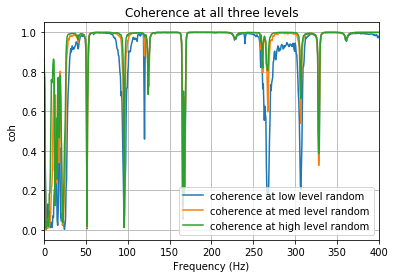

/usr/local/lib/python3.5/dist-packages/numpy/core/numeric.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


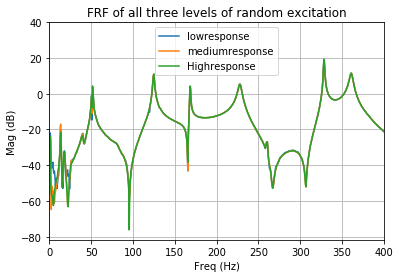

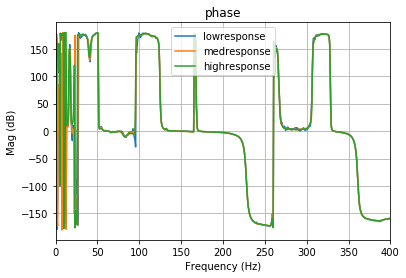

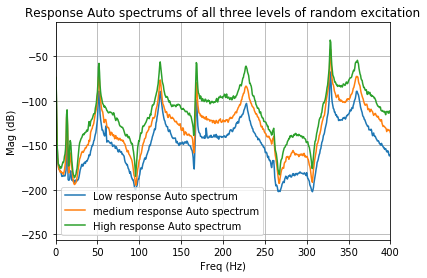

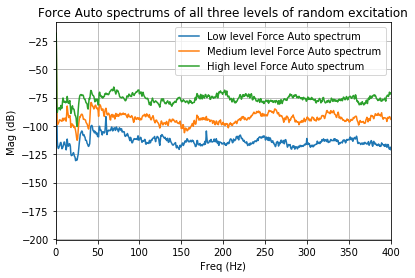

In [10]:
%matplotlib inline
mat_contents=sio.loadmat('linearitycheck/high.mat')
Frequency= mat_contents['Freq_domain']
Frequency= np.array(Frequency)
Highresponse = mat_contents['Hf_chan_2']
Highresponse = np.array(Highresponse)
PSDHighresponse = mat_contents['PSD_chan_2']
PSDHighresponse = np.array(PSDHighresponse)
PSDHighLevelRandom = mat_contents['PSD_chan_1']
PSDHighLevelRandom = np.array(PSDHighLevelRandom)
coh = mat_contents['Hf_coh_chan_2']
Highcoh = np.array(coh)

mat_contents=sio.loadmat('linearitycheck/med.mat')

mediumresponse = mat_contents['Hf_chan_2']
mediumresponse = np.array(mediumresponse)
PSDmediumresponse = mat_contents['PSD_chan_2']
PSDmediumresponse = np.array(PSDmediumresponse)
PSDmediumLevelRandom = mat_contents['PSD_chan_1']
PSDmediumLevelRandom = np.array(PSDmediumLevelRandom)
coh = mat_contents['Hf_coh_chan_2']
Medcoh = np.array(coh)

mat_contents=sio.loadmat('linearitycheck/low.mat')

lowresponse = mat_contents['Hf_chan_2']
lowresponse = np.array(lowresponse)
PSDlowresponse = mat_contents['PSD_chan_2']
PSDlowresponse = np.array(PSDlowresponse)
PSDlowLevelRandom = mat_contents['PSD_chan_1']
PSDlowLevelRandom = np.array(PSDlowLevelRandom)
coh = mat_contents['Hf_coh_chan_2']
Lowcoh = np.array(coh)

FRFs= np.column_stack((lowresponse,mediumresponse,Highresponse))
VibAutospectrum= np.column_stack((PSDlowresponse,PSDmediumresponse,PSDHighresponse))
ForceAutospectrum= np.column_stack((PSDlowLevelRandom,PSDmediumLevelRandom,PSDHighLevelRandom))
coh= np.column_stack((Highcoh, Medcoh, Lowcoh))
coh= np.array(coh)
FRFs=np.array(FRFs)
VibAutospectrum=np.array(VibAutospectrum)
ForceAutospectrum=np.array(ForceAutospectrum)

fig=plt.figure()
plt.title('Coherence at all three levels')
plt.plot(Frequency, Lowcoh,label='coherence at low level random')
plt.plot(Frequency, Medcoh,label='coherence at med level random')
plt.plot(Frequency, Highcoh,label='coherence at high level random')
plt.xlim(xmax=400, xmin=0)
plt.xlabel('Frequency (Hz)')
plt.ylabel('coh')
plt.grid()
plt.legend()
plt.show()


fig=plt.figure()
plt.title('FRF of all three levels of random excitation')

plt.plot(Frequency,20*np.log10(lowresponse), label='lowresponse')
plt.plot(Frequency, 20*np.log10(mediumresponse), label= 'mediumresponse')
plt.plot(Frequency, 20*np.log10(Highresponse), label= 'Highresponse')

plt.xlabel('Freq (Hz)')
plt.ylabel('Mag (dB)')
plt.xlim(xmax=400, xmin=0)
plt.grid()
plt.legend()
plt.show()

fig=plt.figure()
plt.title('phase')
plt.plot(Frequency, np.degrees(np.angle(lowresponse)), label='lowresponse')
plt.plot(Frequency, np.degrees(np.angle(mediumresponse)), label='medresponse')
plt.plot(Frequency, np.degrees(np.angle(Highresponse)), label='highresponse')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Mag (dB)')
plt.grid()
plt.legend()
plt.xlim(xmax=400, xmin=0)
plt.show()

fig=plt.figure()
plt.title('Response Auto spectrums of all three levels of random excitation')

plt.plot(Frequency,20*np.log10(PSDlowresponse), label='Low response Auto spectrum')
plt.plot(Frequency, 20*np.log10(PSDmediumresponse), label= 'medium response Auto spectrum')
plt.plot(Frequency, 20*np.log10(PSDHighresponse), label= 'High response Auto spectrum')

plt.xlabel('Freq (Hz)')
plt.ylabel('Mag (dB)')
plt.xlim(xmax=400, xmin=0)
plt.grid()
plt.legend()
plt.show()

fig=plt.figure()
plt.title('Force Auto spectrums of all three levels of random excitation')

plt.plot(Frequency,20*np.log10(PSDlowLevelRandom), label='Low level Force Auto spectrum')
plt.plot(Frequency, 20*np.log10(PSDmediumLevelRandom), label= 'Medium level Force Auto spectrum')
plt.plot(Frequency, 20*np.log10(PSDHighLevelRandom), label= 'High level Force Auto spectrum')

plt.xlabel('Freq (Hz)')
plt.ylabel('Mag (dB)')
plt.xlim(xmax=400, xmin=0)
plt.grid()
plt.legend()
plt.show()


 ### Observations:
 - We can see at all the levels of the excitation the FRF remains constant which means we are still in the linear behavior of the structure. However, if we zoom in and see we can find rugged edges in the FRF which not good at all. 
 - If we look at the coherence we can choose the best FRF by zooming in, notice that the green signal looks better which is at high level force. So, coherence looks much better with sufficient amount of force.

## 3. Reciprocity Checks

"Maxwell's Reciprocity Theorem" simply stated, a measurement with the excitation at point A and response at point B is equal to the measurement with excitation at point B and the response at point A. So, if the structure is linear then the reciprocity will be good.

(<matplotlib.axes._subplots.AxesSubplot at 0x7fe348afc5c0>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fe348af8c50>)

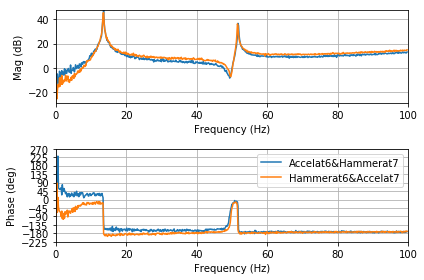

In [13]:
%matplotlib inline
mat_contents=sio.loadmat('reciprocity/accelat6&hammerat7/3.mat')
Frequency= mat_contents['Freq_domain']
Frequency= np.array(Frequency)
FRFat6 = mat_contents['Hf_chan_2']
FRFat6 = np.array(FRFat6)

mat_contents=sio.loadmat('reciprocity/hammerat6&accelat7/1-1.mat')
Frequency= mat_contents['Freq_domain']
Frequency= np.array(Frequency)
FRFat7 = mat_contents['Hf_chan_2']
FRFat7 = np.array(FRFat7)

FRFs= np.column_stack((FRFat6,FRFat7))
FRFs=np.array(FRFs)

vt.frfplot(Frequency,FRFs,freq_min=0,freq_max=100,type=1,legend=['Accelat6&Hammerat7','Hammerat6&Accelat7'])



## 4. Check of Drive Point Measurement

**Drive point:** It is the measured response at the excitation point. If we look at the FRF below we can see that before every resonance we have an anti-resonance all the time, it is consistent. 


##### Demonstration using real data and explanation of Why is it the case,  is below: 

/usr/local/lib/python3.5/dist-packages/numpy/core/numeric.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


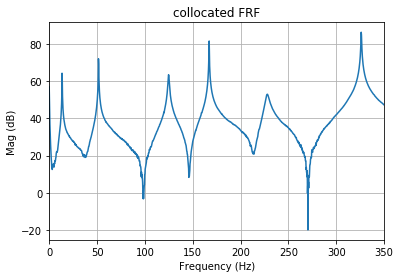

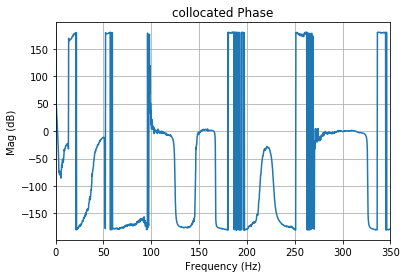

In [46]:
mat_contents=sio.loadmat('modaldata/frf1.mat')
h1 = mat_contents['frf1']
h1 = np.array(h1)
mat_contents=sio.loadmat('modaldata/freqencies.mat')
f = mat_contents['freqencies']
f = np.array(f)
fig=plt.figure()
plt.title('collocated FRF')
plt.plot(f, 20*np.log10(h1))
plt.xlabel('Frequency (Hz)')
plt.ylabel('Mag (dB)')
plt.grid()
plt.xlim(xmax=350, xmin=0)
plt.show()

fig=plt.figure()
plt.title('collocated Phase')
plt.plot(f, np.degrees(np.angle(h1)))
plt.xlabel('Frequency (Hz)')
plt.ylabel('Mag (dB)')
plt.grid()
plt.xlim(xmax=350, xmin=0)
plt.show()


**Observations from the FRF and Why is it the case ?**

- When we are far enough from resonance the phase went up and hit 180 degrees. So, at that point, the two amplitudes are same but one is out-of-phase with the other and because it is out-of-phase, we end up with a subtraction. And that is the reason we get an anti-resonance before we hit next resonance. 
- If we excite anywhere else on the structure except the drive point then it would be sometimes in-phase and sometimes out-of-phase. However, at driving point every resonance is in-phase with each other because they are all pushed with same force in the same direction and when out-of-phase then that is the anti-resonance.
- Depending on the phase of the transducer, they can all be down or up but will be in the same direction.


## 5. Free Mass Validation: 

It is a good check for the impact hammer to conduct free mass validation. This is already explained above in the Impact hammer section.

The same thing can be done with Shaker which is comparatively difficult. We should witness that the phase and the FRF are flat or zero, if that is not the case then there may be a problem. 
![alt](img/freemass)

# Even Experts Have Difficulty

### Case Study1: 

- There was a test object that was sent to a group of Test Engineers to conduct a test to extract FRF and we can see below are the results plotted together that the spread was quite significant considering the math is still the same.

![alt](img/experts)

### Case Study2: GARTEUR "Round Robin" Test: Level 4 DTA

- An aeroplane like specimen was sent to many labs and they were asked to test it for natural frequency and damping. It was found that there was 30% variation in the damping ratio, 4% variation in the resonance frequency. And when they computed a mathematical model for flutter, 13% variation was observed.
- So, we can observe that it is very easy to make a mistake in the damping measurement. We have to be very careful about that.
![alt](img/Garteur)

**Note:** Under the auspices of Group of Aeronautical Research and Technology in Europe (GARTEUR): Twelve experienced GVT units from all of Europe performed the above modal test of the same test specimen. (ref. NLR TP 97086U, 1996) 

# In Summary: Tips and Tricks for best results:

- **Verify measurement chain integrity prior to test:**
  1. Transducer calibration
  2. Mass Ratio calibration


- **Verify suitability of input and output transducers:**
  1. Operating ranges(frequency, dynamic range, phase response)
  2. Mass loading
  3. Mounting
  4. Sensitivity to environmental effects
  5. Stability


- **Verify suitability of test set-up:**
  1. Transducer positioning and alignment 
  2. Pre-test: rattling, boundary conditions, rigid body modes, signal-to-noise ratio, linear approximation, excitation   signal, repeated roots, maxwell reciprocity, force measurement, exciter-input transducer-stringer-structure connection


- **Remember:**
  1. Quality FRF measurements are the foundation of experimental modal analysis
  

- **Select the Proper Resolution**
  1. High resolution = Longer time block
  2. When hammer testing time block is critical!
 

- **Use the Right Window**
  1. Hammer Testing: Uniform or Transient/Exponential Window
  2. Shaker Testing: Uniform or Hanning based in excitation
  3. Apply decay correction on Exponential window
  

- **Pay Attention to Coherence:**
  1. The higher the better
  2. If we have poor coherence, retest the point
  

- **Keep track of the DOFs**
  1. Each measurement is a Degree of Freedom
  2. Direction and location information is critical

# Testing to Analysis

Now, we have FRFs and we want to be able to create our mathematical model. So, we need to decompose this MDOF system in individual SDOF through the curve fitting. The goal is to measure sufficiently large number of points on the structure to be able to characterize the Mode shapes, each resonance has it's own unique mode shape. Firstly, we have to make sure we have good data, do the curve fit and validate the curve fit. 

**Rule of which curve fitter to use:** There are no rules, curve fitting, as much science as it is an art. We need learn, experiment to see which one does the better job for the given conditions, so there no fixed rules.

 ## Modeling the Wing:
 
 We don't  need to have the geometry that represent the wing exactly. An open source experimental modal analysis software called "OpenModal" was used to create a 18 consistent points joined by lines and surfaces to roughly represent the top view of the wing structure. 
 

 
 ![alt](img/wingmodel)

 ## Measurement of FRF Matrix: SISO (One row)
 
* One Roving Hammer Excitation 
* One reference Accel is kept at a fixed location 1
* we intend to impact in minus Z-direction

Time data was collected at 18 points on the wing using NIMAX and Bobcat DAQs with 3 data sets each were averaged.

## Quality of the data check: done of all the FRFs, here demonstrating only one

(0, 350)

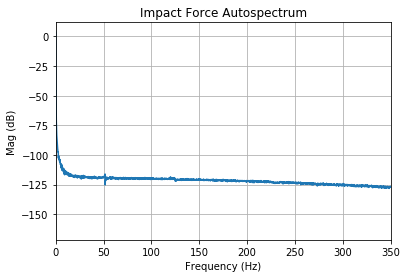

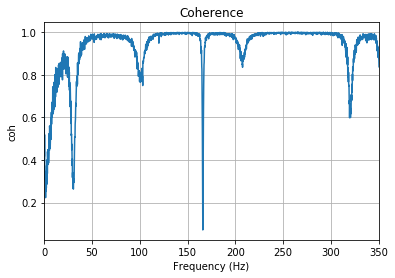

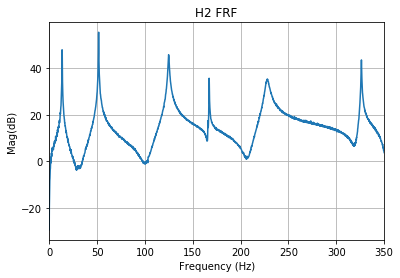

In [51]:
%matplotlib inline
mat_contents=sio.loadmat('modaldata/rawdata_1.mat')
Time_data= mat_contents['Time_domain']
Time_data= np.array(Time_data)
Time_data= np.transpose(Time_data)
rawimpact1 = mat_contents['Time_chan_1']
rawimpact1 = np.array(rawimpact1)
rawresponse1= mat_contents['Time_chan_2']
rawresponse1 = np.array(rawresponse1)
mat_contents=sio.loadmat('modaldata/rawdata_2.mat')
rawimpact2 = mat_contents['Time_chan_1']
rawimpact2 = np.array(rawimpact2)
rawresponse2= mat_contents['Time_chan_2']
rawresponse2 = np.array(rawresponse2)
mat_contents=sio.loadmat('modaldata/rawdata_3.mat')
rawimpact3 = mat_contents['Time_chan_1']
rawimpact3 = np.array(rawimpact3)
rawresponse3= mat_contents['Time_chan_2']
rawresponse3 = np.array(rawresponse3)

x= np.column_stack((rawresponse1,rawresponse2,rawresponse3))
x=np.array([x]).reshape(1,16384,3)

f= np.column_stack((rawimpact1,rawimpact2,rawimpact3))
f=np.array([f]).reshape(1,16384,3)

[freq,Pxx]=vt.asd(x,Time_data,windowname="none")

[freq,Pff]=vt.asd(f,Time_data,windowname="none")

[freq,Pxf]=vt.crsd(f,x,Time_data,windowname="none")

freq=np.array([freq]).reshape(1,8193)


fig=plt.figure()
plt.title('Impact Force Autospectrum')
plt.plot(freq.T, 20*np.log10(abs(Pff)).T)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Mag (dB)')
plt.grid()
plt.xlim(xmax=350, xmin=0)

H1=np.conj(Pxf/Pff)
H2=Pxx/Pxf
coh=(Pxf*np.conj(Pxf)).real/Pxx/Pff

fig=plt.figure()
plt.title('Coherence')
plt.plot(freq.T, coh.T)
plt.xlabel('Frequency (Hz)')
plt.ylabel('coh')
plt.grid()
plt.xlim(xmax=350, xmin=0)

fig=plt.figure()
plt.title('H2 FRF')
plt.plot(freq.T, 20*np.log10(abs(H2)).T)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Mag(dB)')
plt.grid()
plt.xlim(xmax=350, xmin=0)




#### Observation: 
- We have good coherence and force spectrum (giving equivalent amount energy to all the peaks of interest without roll-off) which resulted in a good quality FRF, Since we are more interested in peak amplitude H2 FRF estimator had been choose though it doesn't make much difference even if H1 was choosen as the coherence is good.

### Visually Inspect Data:
  1. Look for obvious modes in FRF
  2. Inspect ALL FRFS...sometimes modes will show up in on FRF but not another (nodes)
  3. Use Imaginary part and coherence for verification
  4. Sum magnitudes of all measurements for clues

### How many points do we need on the structure to do Modal Analysis?

- Building an FE model would be a good way to start with as the FEA can help us to determine the number of points to mathematically separate all modes.
- So, we can create a beam model and after choosing number of nodes and elements that would represent the number of mode shapes that we are interested, if we look at the results there is this third dynamic mode which will not be seen in the experimental results as only  in Z-direction is where sensor would sense, so we neglect it when we calculate MAC later.
- In real world, the tests are done in free-free conditions in that case, if we look at the FE model results then we would see number of rigid body motions but they are all of no interest, only dynamic flexible modes that deform are more important.
- If we see below, we can see 18 points are enough to be able to map all six mode shapes that we are interested in.

![alt](img/Beammodelmode1.jpg)  ![alt](img/Beammodelmode2.jpg)  ![alt](img/Beammodelmodeextra.jpg)  
![alt](img/Beammodelmode3.jpg)  ![alt](img/Beammodelmode4.jpg)  ![alt](img/Beammodelmode5.jpg)  
![alt](img/Beammodelmode6.jpg)


## FRF Data at 18 points

In [12]:
mat_contents=sio.loadmat('modaldata/frf1.mat')
h1 = mat_contents['frf1']
h1 = np.array(h1)
mat_contents=sio.loadmat('modaldata/frf2.mat')
h2 = mat_contents['frf2']
h2 = np.array(h2)
mat_contents=sio.loadmat('modaldata/frf3.mat')
h3 = mat_contents['frf3']
h3 = np.array(h3)
mat_contents=sio.loadmat('modaldata/frf4.mat')
h4 = mat_contents['frf4']
h4 = np.array(h4)
mat_contents=sio.loadmat('modaldata/frf5.mat')
h5 = mat_contents['frf5']
h5 = np.array(h5)
mat_contents=sio.loadmat('modaldata/frf6.mat')
h6 = mat_contents['frf6']
h6 = np.array(h6)
mat_contents=sio.loadmat('modaldata/frf7.mat')
h7 = mat_contents['frf7']
h7 = np.array(h7)
mat_contents=sio.loadmat('modaldata/frf8.mat')
h8 = mat_contents['frf8']
h8 = np.array(h8)
mat_contents=sio.loadmat('modaldata/frf9.mat')
h9 = mat_contents['frf9']
h9 = np.array(h9)
mat_contents=sio.loadmat('modaldata/frf10.mat')
h10 = mat_contents['frf10']
h10 = np.array(h10)
mat_contents=sio.loadmat('modaldata/frf11.mat')
h11 = mat_contents['frf11']
h11 = np.array(h11)
mat_contents=sio.loadmat('modaldata/frf12.mat')
h12 = mat_contents['frf12']
h12 = np.array(h12)
mat_contents=sio.loadmat('modaldata/frf13.mat')
h13 = mat_contents['frf13']
h13 = np.array(h13)
mat_contents=sio.loadmat('modaldata/frf14.mat')
h14 = mat_contents['frf14']
h14 = np.array(h14)
mat_contents=sio.loadmat('modaldata/frf15.mat')
h15 = mat_contents['frf15']
h15 = np.array(h15)
mat_contents=sio.loadmat('modaldata/frf16.mat')
h16 = mat_contents['frf16']
h16 = np.array(h16)
mat_contents=sio.loadmat('modaldata/frf17.mat')
h17 = mat_contents['frf17']
h17 = np.array(h17)
mat_contents=sio.loadmat('modaldata/frf18.mat')
h18 = mat_contents['frf18']
h18 = np.array(h18)
mat_contents=sio.loadmat('modaldata/freqencies.mat')
f = mat_contents['freqencies']
f = np.array(f)

### Measurement validation:

- **Animate the data via the "Function Animation":** This is where it is an advantage of using softwares where we could place a cursor on any location of FRF and animate. Essentially, the cursor just looks at amplitude and phase at every location and plot them using the raw data. So, using raw data, we can click in between two resonance and have the linear combination of the two, it makes more sense when we take the cursor to the peaks. Function animation is also called as method of animating mode shapes by "Peak Picking".
- These mode shapes can be compared later with the original mode shapes obtained from curve fitting. 
- Since the resonances we have here from 0 to 350 Hz are nice and clean, the method of peak picking holds good. However, not every structure is like that, in fact, most structures don't behave like the case here. So, we use suitable way to curve fit.

#### Curve fitting:

- In early days, the curve fit was done only for one resonance and one measurement at a time, it would take long time for the analysis. Today, we have curve fitters that are Multiple degree of freedom curve fitters which curve fit multiple resonances in one shot, that is better because it takes into account the influence of one on the other and in our case we still have extremely easy data set because every peak is well separated and we can see what is going on. However, in some FRF, it is difficult to determine what is going on. So, we need to be able to curve fit multiple resonances in one shot and it is global because it does every measurement together.




- **What is really happening?** The system, by the choice of this polynomial curve fitter is finding out a polynomial equations, Mass, Stiffness and Damping. Each of these, that will match what we see there in terms of resonance frequency, damping and mode shapes. The system start with simple equations and then go up getting more and more terms in the equations, we can suggest the curve fitter for the number of iterations until we find curve fitting is fine.


- **Legends for Symbols:**

     1.     x - once we find frequency, 

     2.   $\ast$ -  Once we find damping and frequency, 

     3.   $\triangledown$ - with frequency, amplitude and phase, 

     4.   $\Diamond$ - finally when every thing is repeatable iteration after iteration, all of them, amplitude, frequency, damping, mode shape	
     


- So, when we find diamond then, it's a good curve fit. However, eventually, things start to break down again because the curve fitter tries to find more and more resonance that do not exist, which means it investigates even the little fluctuations in the FRF, so, we may need too many iterations. Here, in our case we only have six resonances so we don't require too many iteration. However, if we were to do test on 300 accelerometers with 4 shakers that will give us 1200 FRFs then in that case curve fitting will take more time, and we need to be cautious about the number of iterations. We should make sure that we see stable system finally. 


- The curve fitting being done, which is selecting which one of these iterations and modes we want to include in our model that is very interactive in dynamics.


- Which iteration should we take? 3rd or 4th iteration after it became stable would be a good curve fit.


- Once the curve fit is done, we can see the animation and see the curve fit results. If we don't like it, we can just unselect and go to the another one. 


- The complexity is an indication of how in-phase and out-of-phase or if it starts to have some waviness to it.


- Normally, a mode shape is symmetric. However, when we see few modes which are not quite symmetrical that is because we don't have sufficient number of points. This phenomena is called Spacial Aliasing.


- Sometimes interestingly, we see little unwanted glitch of a peak in the FRF which might even be more apparent. So, when we impact perpendicularly then a complete different set of resonances are seen as we know the stiffness in the horizontal axis is not the same as the vertical. Therefore, if we impact at an angle by mistake that means we partly excited the cross axis which will be seen in our measurement in the form of a little glitch that belongs to the cross axis resonances.



- It is important to understand that the natural frequency and the damping ratio are global properties which means no matter at which point we test they remain same. 


- The mode shapes or the better way to look it is in terms of the amplitude and the phase are local properties, they are different at each point we measure.




# Determining the best method to curve fit

### Curve Fitting Techniques

**Single Degree of Freedom (SDOF)**


- SDOF Polynomial
- Circle Fit


**Multi Degree of Freedom**


- MDOF Polynomial
- Complex Exponential
- Direct Parameter
- Polyreference
- ...................

### Modal Analysis - Step by Step Process:


  
  
**- Select Curve Fitter:**
  1. Lightly coupled modes: SDOF techniques
  2. Heavily coupled modes: MDOF techniques
  3. Stable measurements: Global techniques
  4. Unstable measurements: Local techniques
  5. MIMO measurement: Poly reference techniques


**- Analysis:**
  1. Use more than 1 curve fitter to see if they agree
  2. Do mode shapes make sense?

### SDOF Polynomial Curve Fitting

### MDOF Polynomial Curve Fitting

In [15]:

TF= np.column_stack((h1,h2,h3,h4,h5,h6,h7,h8,h9,h10,h11,h12,h13,h14,h15,h16,h17,h18))
[Damping1,naturalfreq1,U1]=vt.mdof_cf(f,TF,40,70)
[Damping2,naturalfreq2,U2]=vt.mdof_cf(f,TF,165,255)
[Damping3,naturalfreq3,U3]=vt.mdof_cf(f,TF,470,560)
[Damping4,naturalfreq4,U4]=vt.mdof_cf(f,TF,640,730)
[Damping5,naturalfreq5,U5]=vt.mdof_cf(f,TF,890,980)
[Damping6,naturalfreq6,U6]=vt.mdof_cf(f,TF,1290,1390)

### Least-Squares Complex frequency domain method:

The LSCF method is an frequency-domain Linear Least Squares estimator optimized  for modal parameter estimation. The choice of the most important algorithm characteristics is based on the results in [1] (Section 5.3.3.) and can be summarized as:
- Formulation: the normal equations are constructed for the common denominator discrete-time model in the Z-domain. Consequently, by looping over the outputs and inputs, the submatrices Rk, Sk, and Tk are formulated through the use of the FFT algorithm as Toeplitz structured (n+1) square matrices. Using complex coefficients, the FRF data within the frequency band of interest (FRF-zoom) is projected in the Z-domain in the interval of [0, 2*pi] in order to improve numerical conditioning. (In the case that real coefficients are used, the data is projected in the interval of [0, pi].) The projecting on an interval that does not completely describe the unity circle, say [0, alpha*2*pi] where alpha is typically 0.9-0.95. Deliberately over-modeling is best applied to cope with discontinuities. This is justified by the use of a discrete time model in the Z-domain, which is much more robust for a high order of the transfer function polynomials.
- Solver: the normal equations can be solved for the denominator coefficients ThetaA by computing the Least-Squares (LS) or mixed Total-Least-Squares (TLS) solution. The inverse of the square matrix D for the LS solution is computed by means of a pseudo inverse operation for reasons of numerical stability, while the mixed LS-TLS solution is computed using an SVD (Singular Value Decomposition).

In [ ]:
lscf(frf, low_lim, n, dt, weighing_type='Unity', reconstruction='LSFD'):

### Least-Squares Complex Exponential method: 

The Least-Squares Complex Exponential method (LSCE), is the extension of the Complex Exponential method (CE) to a global procedure. It is therefore a SIMO method, processing simultaneously several IRFs obtained by exciting a structure at one single point and measuring the responses at several locations. With such a procedure, a consistent set of global parameters (natural frequencies and damping factors) is obtained, thus overcoming the variations obtained in the results for those parameters when applying the CE method on different IRFs.

In [ ]:
lsce(frf, f, low_lim, nmax, dt, input_frf_type ='d', additional_timepoints=0,
reconstruction='LSFD'):

### Curve Fitting Methods

Based upon measuring 1 row or 1 column of the frequency response matrix

**Single Mode Methods**
- Fast
- Easy to use
- Errors can occur with heavy Modal Coupling

**Multiple Mode Methods**
- Handle Modal Coupling
- Require more operator skill

### Advanced Curve Fitters

**Global Curve Fitter**
- frequency and damping are estimated globally from all measurements using the methods of least squares and polynomial fit model
- residues are calculated from all measurements using the global damping values

**Polyreference Curve Fitter**
- used for identification of repeated roots
- two or more columns or rows of the FRF matrix are measured
- A global curve fitter using the polynomial fit model

### Performing Modal Analysis

- Select a frequency (time) range
  - Out of bound modes
- Select an algorithm
- Choose the number of iterations for the dataset
- Select poles
  - Understanding the stability diagram
- Synthesis (Curve fit)
- Validation

**Mode Indicator Function:**

MIF goes through all of the FRFs, here we only have 18 FRFs, many tests have hundreds of those. But it goes through all of those and globally determine whether we have a mode or not. For instance, if at some of these measurements there is no motion then we can't have only one measurement to determine that. So, globally there are few of these indicating functions some pointing up and some coming down(in green). But we can see that the drop coincide very well with the red FRF data set. 

 ![alt](img/MIF)

The yellow selection box is the delta indication which helps us decide the number of resonances to curve fit. 

**MIF FRF**
- Single or Multiple references
- Data quality
- Easier frequency range selection
  - Anti-resonance
- Historical
- No indication of repeated roots
  - Repeated roots refer to the situation where on of the complex roots (modal frequency, eigen value, pole, etc.) occurs more than once in the characteristic equation.

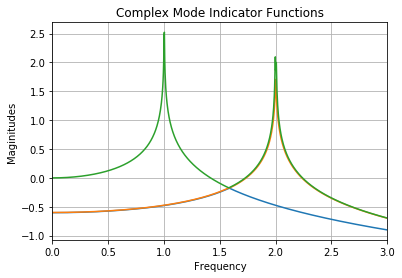

In [142]:
import vibrationtesting as vt
M = np.diag([1,1,1])
K = K = np.array([[3.03, -1, -1],[-1, 2.98, -1],[-1, -1, 3]])
Damping = K/100
Cd = np.eye(3)
Cv = Ca = np.zeros_like(Cd)
Bt = np.eye(3)
H_all = np.zeros((3,1000,3), dtype = 'complex128')
for i in np.arange(1, 4):
    for j in np.arange(1, 4):
        omega, H_all[i-1,:,j-1] = vt.sos_frf(M, Damping/10, K, Bt,
                                             Cd, Cv, Ca, 0, 3, i,
                                             j, num_freqs = 1000)
cmfi = vt.cmif(omega, H_all)



### Analysis Validation

The Validation process consist into 5 steps required to validate modal results to make sure the curve fitting process was done properly and real modes have been selected and that errors like mode duplication due to variable mass loading have been avoided:

- Animation
- Mode Normalization
- FRF Synthesis
- AutoMAC
- CrossMAC

### Animation of Mode Shapes from Modal Analysis:

One of the good ways to validate the analysis


![alt](img/shape1) ![alt](img/shape2)  ![alt](img/shape3)  ![alt](img/shape4)  ![alt](img/shape5)  ![alt](img/shape6)

### Mode Normalization

If we did a perfect measurement on a very normal structure, every thing should be perfectly in-phase or perfectly out-of-phase. When we see a little bit spread out then that could be due to the way we impacted the structure. The higher frequencies spread out  a little more and that is perfectly normal. 
The more spread we have, the more waviness we will witness in the mode shape. It should be in phase, should not look like it's traveling.
So, for a pure normal mode, all the DOF are either in phase or out of phase(-180 deg). Noise mode or poor FRF data would result in a random spread of phase and amplitude.

### Analysis Validation - Synthesis

The Synthesis will use the data reduction results (curve fit results, that is the shape table), and through the polynomial equation recalculate the FRF for each DOF

The overly of the Actual measured FRF and Synthesized FRF is an excellent measure of the exactitude of the whole Modal Analysis process from Acquisition to FRF calculation and curve fitting.

### Analysis Validation

What is Correlation?

- Correlation is the relationship between two or more things. Correlating is comparing two data sets and establishing a level of coherence or similarity between the two datasets.


- Correlation is a broad term often overloaded in Structural Dynamics. Customer will often refer to correlation when discussing:
        
     - Pretest Planning
     - Model Updating
     - Vector Comparison



## MAC:

The Modal Assurance Criterion (MAC) analysis is used to determine the similarity of two mode shapes:

* If the mode shapes are identical (i.e., all points move the same) the MAC will have a value of one or 100%. 
* If the mode shapes are very different, the MAC value will be close to zero.
 
*Note: A MAC analysis is only looking at the mode shape, it does not compare the frequency value.* 
 
### MAC Equation:
 
The MAC value between two modes is essentially the normalized dot product of the complex modal vector at each common nodes (i.e., points), as shown in Equation.  It can also be thought of as the square of correlation between two modal vectors φr and φs. Equation below is the Modal Assurance Criterion equation for comparing two mode shapes:



![alt](img/image.png)


If a linear relationship exists (i.e., the vectors move the same way) between the two complex vectors, the MAC value will be near to one. If they are linearly independent, the MAC value will be small (near zero).
 
A complex vector simply includes both amplitude and phase, whereas a real vector is real part only. In Equation, it is also clear that the MAC is not sensitive to scaling, so if all mode shape components are multiplied with the same factor, the MAC will not be affected.

If an experimental modal analysis had 18 different nodes where measurements were made, the mode shape components at all 18 nodes are taken into account to calculate the MAC value, but more importance will be attributed to the higher amplitude node locations.
             


### Resulting Eigen Vectors from Testing:

Here, considered the case of an experimental modal analysis performed on a wing, suspended free on one end and clamped on the other. Frequency Response Function (FRF) data was acquired at 18 locations on the wing. The FRF data was analyzed and a mode set extracted. 

In [16]:
mat_contents=sio.loadmat('Modeshapedata/1stNaturalFreq15.mat')
U1 = mat_contents['U1']
mat_contents=sio.loadmat('Modeshapedata/2ndNaturalFreq15.mat')
U2 = mat_contents['U2']
mat_contents=sio.loadmat('Modeshapedata/3rdNaturalFreq15.mat')
U3 = mat_contents['U3']
mat_contents=sio.loadmat('Modeshapedata/4rthNaturalFreq15.mat')
U4 = mat_contents['U4']
mat_contents=sio.loadmat('Modeshapedata/5thNaturalFreq15.mat')
U5 = mat_contents['U5']
mat_contents=sio.loadmat('Modeshapedata/6thNaturalFreq15.mat')
U6 = mat_contents['U6']
Psi_1 = np.array(U1)
Psi_2 = np.array(U2)
Psi_3 = np.array(U3)
Psi_4 = np.array(U4)
Psi_5 = np.array(U5)
Psi_6 = np.array(U6)
Psi_1=np.column_stack((Psi_1,Psi_2,Psi_3,Psi_4,Psi_5,Psi_6))
Psi_abs = np.abs(Psi_1)*np.real(np.sign(Psi_1))
Psi_1 = Psi_abs


### Test-Test Comparison:

The important thing to remember while we do modal analysis is that, when we have some sort of a structure, then we need to know how many points along the structure to test. For instance, initially, the wing structure was tested taking a guess of number of points as nine to capture all of our mode shapes accurately, however, it was noticed that the modes seen essentially looks like rigid body motion at higher frequencies.

It is quite similar to aliasing, when we think about reading in frequencies where we did not sample high enough, but here its about not considering enough points on the structure. So, one way to check that enough points were used to accurately capture all versus different mode shapes by using something called the MAC matrix.

In [17]:
vt.mac(Psi_1,Psi_1)

array([[ 1.         ,  0.012878134,  0.024564134,  0.021402321,  0.04530025 ,  0.00297411 ],
       [ 0.012878134,  1.         ,  0.05357427 ,  0.003010583,  0.008900821,  0.01555768 ],
       [ 0.024564134,  0.05357427 ,  1.         ,  0.002131827,  0.162034548,  0.00183518 ],
       [ 0.021402321,  0.003010583,  0.002131827,  1.         ,  0.000965057,  0.020653144],
       [ 0.04530025 ,  0.008900821,  0.162034548,  0.000965057,  1.         ,  0.000017919],
       [ 0.00297411 ,  0.01555768 ,  0.00183518 ,  0.020653144,  0.000017919,  1.         ]])

Acquiring an additional 9 points leads to better results.  With 18 total points, the mode shapes look completely different. So, with less response points, the spatial aliasing error was created.

*Note: The term used of "not enough response points" is called "Spacial Aliasing".*

In the above case, this is a mode set compared to itself.  The mode set contains six different individual modes, so 36 different MAC values are being calculated. About half the values are redundant –e.g., the MAC value between mode 1 and 3 is the same as between mode 3 and 1.

The first mode shape at 13 Hz is identical to itself, hence a value of 1. Along the diagonal, every mode is identical to itself, 1 to 1 (13 Hz), 2 to 2 (51 Hz), 3 to 3 (121 Hz), etc.

If the off-diagonal MAC values are very low then that means the modes are not coherent to each other, they are completely separated, the accurate word being completely orthogonal(very different).  Ideally, each mode should be uniquely observed and have a different shape than the other modes.  This is the case for this mode set.  The highest off diagonal mode pair is mode 5 compared to mode 3 (and vice versa 3 to 5) with a MAC value of 16%. All the other off-diagonal mode pairs are below 16%. 

In experimental modal analysis, the data measured in the 9 point modal analysis is not "wrong". The FRF measurements at these nodes were no different in the 9 point modal versus the 18 point, since the physical structure being tested did not change.  There was simply not enough measurement points to determine the complete mode shape.  This is different than a Finite Element modal analysis were the number of nodes does determine the dynamic behavior.

**Reasons for higher off-diagonal terms in Auto MAC(For Test results):**
- Measurement problem
- Curve fit problem
- Spacial Aliasing

### Analysis Validation - Cross Mac

The CrossMac allows to compare two different shape tables obtained by two different curve fitting process. A good diagonal table will show that the two method agrees. Here we compare the Polynomial method with the Complex Exponential method and both aggress very well.

Again off diagonal values should be very low.

In [ ]:
vt.mac(Psi_1,Psi_1)

### Beam Element model: 

A Matlab code was developed to solve different problems using 3D beam/rod/torsion element inside WFEM module by simply creating an input file.  The following were the resultant natural frequencies and mode shapes:

## Resulting eigen vectors from FE model:

In [37]:
mat_contents=sio.loadmat('FEmodaldata/WingBeamforMAC.mat')
K = (mat_contents['Kr'])
M = (mat_contents['Mr'])
Kbm = K.todense()
Mbm = M.todense()
omega, zeta, PsiBM = vt.sos_modal(Mbm, Kbm)
Psi_1 = PsiBM
mode1=Psi_1[:,0]
mode2=Psi_1[:,1]
mode3=Psi_1[:,3]
mode4=Psi_1[:,4]
mode5=Psi_1[:,5]
mode6=Psi_1[:,6]
Psi_2BM= np.column_stack((mode1, mode2, mode3, mode4, mode5, mode6))

### Brick Element model:

Similar to Beam code, an 8 noded Brick element was developed. The following are results obtained:

### Observations:

1. Beam model gave better results with lesser mesh compared to Brick model. Thereby saving computational time.


In [39]:
mat_contents=sio.loadmat('FEmodaldata/WingBrickmuchMorMeshedforMAC1.mat')
K = (mat_contents['Kr'])
M = (mat_contents['Mr'])
Kbr = K.todense()
Mbr = M.todense()
omega, zeta, PsiBR = vt.sos_modal(Mbr, Kbr)
Psi_1 = PsiBR
mode1=Psi_1[:,0]
mode2=Psi_1[:,1]
mode3=Psi_1[:,3]
mode4=Psi_1[:,4]
mode5=Psi_1[:,5]
mode6=Psi_1[:,6]
Psi_2BR= np.column_stack((mode1, mode2, mode3, mode4, mode5, mode6))




![alt](img/Brickmodelmode1.jpg) | ![alt](img/Brickmodelmode2.jpg) | ![alt](img/Brickmodelmode3.jpg) 

![alt](img/Brickmodelmode4.jpg) | ![alt](img/Brickmodelmode5.jpg) | ![alt](img/Brickmodelmode6.jpg)

### FE-FE comparison:

The below off-diagonal MAC values tell how bad the assumptions made were. We can observe that off-diagonal terms for the Brick model look better because of more mesh.


In [29]:
vt.mac(Psi_2BM,Psi_2BM)

array([[ 1.         ,  0.28416901 ,  0.172196744,  0.         ,  0.132407293,  0.         ],
       [ 0.28416901 ,  1.         ,  0.371274112,  0.         ,  0.235979076,  0.         ],
       [ 0.172196744,  0.371274112,  1.         ,  0.         ,  0.379744752,  0.         ],
       [ 0.         ,  0.         ,  0.         ,  1.         ,  0.         ,  0.240949039],
       [ 0.132407293,  0.235979076,  0.379744752,  0.         ,  1.         ,  0.         ],
       [ 0.         ,  0.         ,  0.         ,  0.240949039,  0.         ,  1.         ]])

In [30]:
vt.mac(Psi_2BR,Psi_2BR)

array([[ 1.         ,  0.122984639,  0.041348987,  0.         ,  0.026004283,  0.         ],
       [ 0.122984639,  1.         ,  0.157153609,  0.         ,  0.060581719,  0.         ],
       [ 0.041348987,  0.157153609,  1.         ,  0.         ,  0.168759104,  0.         ],
       [ 0.         ,  0.         ,  0.         ,  1.         ,  0.         ,  0.10115887 ],
       [ 0.026004283,  0.060581719,  0.168759104,  0.         ,  1.         ,  0.         ],
       [ 0.         ,  0.         ,  0.         ,  0.10115887 ,  0.         ,  1.         ]])

### Correlation FEM vs. Test

**Difference between FEM and Test:**
- Many more FEM DOF's than Test DOF's
     - More FEM DOF's are required for the model accuracy
        - FEM models are made of nodes and elements
     - Cost, complexity and mass loading limit the number of test DOF's
- Test DOF's may not be collocated with FEM DOF's
- Test and FEM may have different orientations
- FEM models do not typically incorporate damping
- Test modes typically are complex modes
- Mode Scaling and units can be different 
- A Mass and Stiffness matrix are calculated during the FEM solution
- A Mass, Stiffness and Damping matrix cannot be estimated from a Modal Test
- Boundary Conditions: Fixed or Free-Free?

### Geometry Alignment:

After Alignment is done Geometry are referring to the same coordinate system
    

### DOF Mapping:
    
A "DOF Map Table" will be calculated using the FEM results and Test shapes. Here each Test node will be mapped to a corresponding FEM node.

###### Extension of modes from Modal Analysis to All DOF of a Finite Element Model after applying Guyan reduction:

Only guyan reduction was applied on the full M and K from the created model using WFEM module(Matlab) to reduce the M and K matrix. SEREP could be applied to reduce the M and K matrices further, however, in this case it would not give accurate results as only 6 mode shapes are retained which would result in a very small 6x6 sized M and K matrices.

In [20]:
mat_contents=sio.loadmat('FEmodaldata/WingBeamforMAC.mat')
K = (mat_contents['Kr'])
M = (mat_contents['Mr'])
Kbm = K.todense()
Mbm = M.todense()
omega, zeta, PsiBM = vt.sos_modal(Mbm, Kbm)
measured = np.array([[1,6,11,16,21,26,31,36,41,46,51,56,61,66,71]])
omega=np.array([omega[0], omega[1], omega[3], omega[4], omega[5], omega[6]])
Psi_fullBM=vt.mode_expansion_from_model(Psi_1, omega, Mbm, Kbm, measured)


In [21]:
mat_contents=sio.loadmat('FEmodaldata/WingBrickmuchMorMeshedforMAC1.mat')
K = (mat_contents['Kr'])
M = (mat_contents['Mr'])
Kbr = K.todense()
Mbr = M.todense()
omega, zeta, PsiBR = vt.sos_modal(Mbr, Kbr)
measured = np.array([[350, 347, 344, 278, 275, 272, 206, 203, 200, 134, 131, 128, 62, 59, 56]])
omega=np.array([omega[0], omega[1], omega[3], omega[4], omega[5], omega[6]])
Psi_fullBR=vt.mode_expansion_from_model(Psi_1, omega, Mbr, Kbr, measured)


So, the alternative to reducing the matrices from the finite element model is to expand the measured mode shape vectors to estimate the data at unmeasured locations. Expanding the measured data invariably involves using the finite element model to fill in the missing data. The vibration testing module in python has the function mode_expansion_from_model which does the expansion process for us.


### FE-Test Comparison:

After collecting Frequency Response Functions (FRFs) on the wing, a MAC analysis was done between the first six experimental test modes and the first six finite element analysis modes. The results are shown below.


In [31]:
vt.mac(Psi_fullBM,Psi_2BM)

array([[ 0.902776121,  0.08397938 ,  0.133234332,  0.000280447,  0.069636931,  0.000567165],
       [ 0.157055975,  0.892874372,  0.1246398  ,  0.000251338,  0.095492976,  0.000255381],
       [ 0.029469884,  0.217923327,  0.896786436,  0.000113918,  0.154537904,  0.000015324],
       [ 0.009130519,  0.00258551 ,  0.001044216,  0.10351289 ,  0.00068626 ,  0.087508   ],
       [ 0.071166016,  0.067331544,  0.34484064 ,  0.000039387,  0.854315037,  0.000332692],
       [ 0.007015925,  0.009076935,  0.000333458,  0.899795777,  0.001109486,  0.124936721]])

In [32]:
vt.mac(Psi_fullBR,Psi_2BR)

array([[ 0.419687707,  0.000826393,  0.002039278,  0.000059746,  0.004514538,  0.000070361],
       [ 0.010436219,  0.383714861,  0.000050142,  0.000000193,  0.001243138,  0.000022064],
       [ 0.038379026,  0.000165336,  0.299634258,  0.000027009,  0.000093382,  0.000075664],
       [ 0.017322709,  0.001122434,  0.000278439,  0.492081088,  0.000266308,  0.014127599],
       [ 0.013926318,  0.069706433,  0.002956606,  0.000573113,  0.236123559,  0.000164655],
       [ 0.004917083,  0.007407191,  0.003720332,  0.005166634,  0.000011543,  0.428847769]])

Looking at the diagonal and off-diagonal of the MAC matrix:

Beam model observations: 

* Diagonal MAC values are not 100%, because the two sets of modes are not identical.
* Modes 4 and 6 are less than 25%, the reason being torsional modes.
* The highest off diagonal mode pair is mode 5 compared to mode 3 (and vice versa 3 to 5) with a MAC value of 34%. All the other off-diagonal mode pairs are below 16%.

Brick model:

* Diagonal MAC values are not even 50%, may be because the mode shape locations did not match well.
* Similar to the Beam model, torsional modes have very less diagonal MAC values. 
* The highest off diagonal mode pair is mode 1 compared to mode 3 (and vice versa 3 to 1) with a MAC value of 3%. All the other off-diagonal mode pairs are below 3%.

In this case, the MAC analysis indicates that there is room for improvement in the correlation of the test and FEA. This 
can be done by correcting the M and K from FE model using 'Baruch' method

### FE model Correction:

Baruch method of model correction is a Direct model updating Technique using modal data. This can be simply be performed using the model_correction_direct function in the vibration testing module in Python.


In [33]:
omega=np.array([13.54, 51.81, 125.19, 167.76, 228.05, 328.41])
Mc, Kc = vt.model_correction_direct(Psi_fullBM, omega, Mbm, Kbm, method='Baruch')
omega, zeta, PsiBM = vt.sos_modal(Mc, Kc)
Psi_2 = PsiBM
mode1=Psi_2[:,0]
mode2=Psi_2[:,1]
mode3=Psi_2[:,2]
mode4=Psi_2[:,3]
mode5=Psi_2[:,4]
mode6=Psi_2[:,5]
Psi_2BM= np.column_stack((mode1, mode2, mode3, mode4, mode5, mode6))

In [34]:
omega=np.array([13.54, 51.81, 125.19, 167.76, 228.05, 328.41])
Mc, Kc = vt.model_correction_direct(Psi_fullBR, omega, Mbr, Kbr, method='Baruch')
omega, zeta, PsiBR = vt.sos_modal(Mc, Kc)
Psi_2 = PsiBR
mode1=Psi_2[:,0]
mode2=Psi_2[:,1]
mode3=Psi_2[:,2]
mode4=Psi_2[:,3]
mode5=Psi_2[:,4]
mode6=Psi_2[:,5]
Psi_2BR= np.column_stack((mode1, mode2, mode3, mode4, mode5, mode6))

In [35]:
vt.mac(Psi_fullBM,Psi_2BM)

array([[ 0.881321121,  0.038974652,  0.026369503,  0.022319756,  0.043063273,  0.004626752],
       [ 0.151688823,  0.966339971,  0.083540347,  0.000101145,  0.00984486 ,  0.012454445],
       [ 0.026114408,  0.130064798,  0.985585275,  0.000779997,  0.146162695,  0.000792393],
       [ 0.000705308,  0.000182381,  0.000003272,  0.958222761,  0.000485955,  0.055843798],
       [ 0.016009234,  0.033694923,  0.135101087,  0.00022769 ,  0.999311401,  0.000000001],
       [ 0.000009955,  0.001125275,  0.002966466,  0.116284286,  0.000000452,  0.990680361]])

In [36]:
vt.mac(Psi_fullBR,Psi_2BR)

array([[ 0.698262238,  0.000359566,  0.001196876,  0.033783873,  0.000001657,  0.002985744],
       [ 0.08548994 ,  0.798983181,  0.011013081,  0.000197895,  0.016457018,  0.014427994],
       [ 0.01609378 ,  0.065317434,  0.895059712,  0.001135323,  0.055996187,  0.003718399],
       [ 0.025364975,  0.003495387,  0.004594898,  0.96107467 ,  0.000053346,  0.018941836],
       [ 0.013595906,  0.008849519,  0.049541316,  0.000901858,  0.978078484,  0.001089207],
       [ 0.004008585,  0.002180803,  0.030543414,  0.052915722,  0.000170555,  0.987921688]])

So, after updating the model the MAC matrix results improved drastically. When comparing the three observations made before correcting the model to after correcting:

* MAC values are still not 100%, but very close enough .
* MAC values of the torsional modes were improved to great extent.
* The highest off diagonal mode pair is mode 5 compared to mode 3 (and vice versa 3 to 5) with a MAC value of 34% before is now 13.5%. All the other off-diagonal mode pairs are below 16%. Thats for the Beam model. However, for the Brick off-diagonal terms increased.


### Uses:

A Modal Assurance Criterion (or MAC) analysis can be used in several different ways:

- Test-Test comparison – A MAC analysis can flag potential issues with the modal analysis results. Usually MAC will identify modes and areas that could benefit from acquiring more data points on the structure.


- FEA-FEA comparison – Several assumptions can be made in the creation of a FEA analysis: Young’s Modulus, boundary conditions, and mass density values to name a few. A MAC analysis can determine the degree to which these assumptions affect the resulting mode shapes.


- FEA-Test comparison – A MAC can be used to compare modes from an experimental modal analysis test to a Finite Element Analysis (FEA). It will indicate if the same mode shapes are found in both the test and FEA analysis.



### Conclusion:

A Modal Assurance Criterion (or MAC) analysis can be used for FEA-Test, FEA-FEA and Test-Test comparisons of modes. By analyzing a MAC matrix, an engineer can improve the quality of an experimental modal test, verify finite element models, and update FEA models with test data.